In [1]:
!apt update > /dev/null && apt upgrade > /dev/null
!pip install kaggle > /dev/null



W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


Extracting templates from packages: 100%


In [3]:
import kagglehub
import os

# Download latest version
# path 현재 파일이 다운로드된 경로
path = kagglehub.dataset_download("computingvictor/transactions-fraud-datasets")

os.chdir(path) # 경로를 현재 다운로드된 파일들이 있는 경로로 변경
print(os.getcwd()) # 현재 폴더 경로; 작업 폴더 기준
print(os.listdir(os.getcwd()))

100%|██████████| 348M/348M [00:08<00:00, 41.4MB/s]

Extracting files...


/root/.cache/kagglehub/datasets/computingvictor/transactions-fraud-datasets/versions/1
['users_data.csv', 'train_fraud_labels.json', 'mcc_codes.json', 'cards_data.csv', 'transactions_data.csv']


병합

In [4]:
import pandas as pd
import json

with open('train_fraud_labels.json') as f:
    js = json.loads(f.read())
fraud = pd.DataFrame(js)
fraud = fraud.reset_index()
fraud.columns = ["id", "fraud"]

fraud['id'] = fraud['id'].astype(str)
fraud['fraud'] = fraud['fraud'].astype(str)

file_path = "transactions_data.csv"
trans = pd.read_csv(file_path)
columns_to_keep = ["id", "client_id"]
# 특정 컬럼만 남기기
trans = trans[columns_to_keep]

trans['id'] = trans['id'].astype(str)
trans['client_id'] = trans['client_id'].astype(str)

merge = pd.merge(fraud, trans, on='id')

file_path = "users_data.csv"
card = pd.read_csv(file_path)

columns_to_keep = ["id", "current_age"]

# 특정 컬럼만 남기기
card = card[columns_to_keep]

print(card.head())
print(card.dtypes)

card['id'] = card['id'].astype(str)
card['current_age'] = card['current_age'].astype(str)

card.columns = ["client_id", "current_age"] # 다른 파일들에선 client_id = 현 파일에서의 id

merge = pd.merge(merge, card, on='client_id')

print(merge.head())
columns_to_keep = ["fraud", "current_age"]
# 특정 컬럼만 남기기
merge = merge[columns_to_keep]
print(merge.head())

     id  current_age
0   825           53
1  1746           53
2  1718           81
3   708           63
4  1164           43
id             int64
current_age    int64
dtype: object
         id fraud client_id current_age
0  10649266    No        11          39
1  23410063    No       609          59
2   9316588    No      1094          34
3  12478022    No       944          58
4   9558530    No       895          46
  fraud current_age
0    No          39
1    No          59
2    No          34
3    No          58
4    No          46


나이의 최대값과 최소값 확인

In [11]:
merge['current_age'] = merge['current_age'].astype(int) # 이렇게 안하면 최소값이 101이고 최대값이 99인 매직이 일어납니다.

max = merge['current_age'].max()
min = merge['current_age'].min()

print(f'최대값: {max}')
print(f'최소값: {min}')

최대값: 101
최소값: 23


20대, 30대, 40대
10연대로 구분하겠다.
그 후 막대그래프로 시각화

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54943 (\N{HANGUL SYLLABLE HOES}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45208 (\N{HANGUL SYLLABLE NA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPy

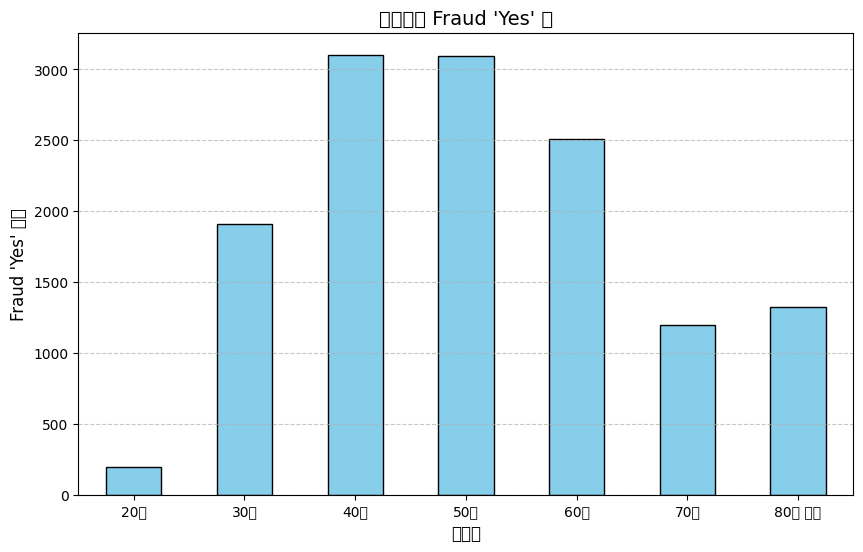

In [12]:
import matplotlib.pyplot as plt
# 나이대를 정의
def age_group(age):
    if age < 30:
        return "20대"
    elif age < 40:
        return "30대"
    elif age < 50:
        return "40대"
    elif age < 60:
        return "50대"
    elif age < 70:
        return "60대"
    elif age < 80:
        return "70대"
    else:
        return "80대 이상"

# 나이대 컬럼 추가
merge["age_group"] = merge["current_age"].apply(age_group)

# fraud가 'Yes'인 경우만 필터링하여 나이대별 그룹화
fraud_yes_counts = merge[merge["fraud"] == "Yes"].groupby("age_group").size()

# 누락된 나이대를 0으로 채움
all_age_groups = ["20대", "30대", "40대", "50대", "60대", "70대", "80대 이상"]
fraud_yes_counts = fraud_yes_counts.reindex(all_age_groups, fill_value=0)

# 막대그래프 시각화
plt.figure(figsize=(10, 6))
fraud_yes_counts.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("나이대별 Fraud 'Yes' 수", fontsize=14)
plt.xlabel("나이대", fontsize=12)
plt.ylabel("Fraud 'Yes' 횟수", fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

5번

성별과 나이대를 동시에 가지는 데이터 생성
나이대별 어떤 성별이 사기거래에 당했는지를 알기 위해 시각화

In [14]:
import pandas as pd
import json

with open('train_fraud_labels.json') as f:
    js = json.loads(f.read())
fraud = pd.DataFrame(js)
fraud = fraud.reset_index()
fraud.columns = ["id", "fraud"]

fraud['id'] = fraud['id'].astype(str)
fraud['fraud'] = fraud['fraud'].astype(str)

file_path = "transactions_data.csv"
trans = pd.read_csv(file_path)
columns_to_keep = ["id", "client_id"]
# 특정 컬럼만 남기기
trans = trans[columns_to_keep]

trans['id'] = trans['id'].astype(str)
trans['client_id'] = trans['client_id'].astype(str)

merge = pd.merge(fraud, trans, on='id')

file_path = "users_data.csv"
card = pd.read_csv(file_path)

columns_to_keep = ["id", "current_age", "gender"]

# 특정 컬럼만 남기기
card = card[columns_to_keep]

print(card.head())
print(card.dtypes)

card['id'] = card['id'].astype(str)
card['current_age'] = card['current_age'].astype(str)
card['gender'] = card['gender'].astype(str)

card.columns = ["client_id", "current_age", "gender"] # 다른 파일들에선 client_id = 현 파일에서의 id

merge = pd.merge(merge, card, on='client_id')

print(merge.head())
columns_to_keep = ["fraud", "current_age", "gender"]
# 특정 컬럼만 남기기
merge = merge[columns_to_keep]
print(merge.head())

     id  current_age  gender
0   825           53  Female
1  1746           53  Female
2  1718           81  Female
3   708           63  Female
4  1164           43    Male
id              int64
current_age     int64
gender         object
dtype: object
         id fraud client_id current_age  gender
0  10649266    No        11          39  Female
1  23410063    No       609          59    Male
2   9316588    No      1094          34    Male
3  12478022    No       944          58    Male
4   9558530    No       895          46  Female
  fraud current_age  gender
0    No          39  Female
1    No          59    Male
2    No          34    Male
3    No          58    Male
4    No          46  Female


한글이 깨지지 않도록 설정

In [15]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following packages were automatically installed and are no longer required:
  linux-headers-5.15.0-125 linux-headers-5.15.0-125-generic
Use 'sudo apt autoremove' to remove them.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 4 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (11.8 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debco

한글 폰트 설정

In [16]:
import matplotlib.pyplot as plt
import numpy as np

plt.rc('font', family='NanumBarunGothic')

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54943 (\N{HANGUL SYLLABLE HOES}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45208 (\N{HANGUL SYLLABLE NA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPy

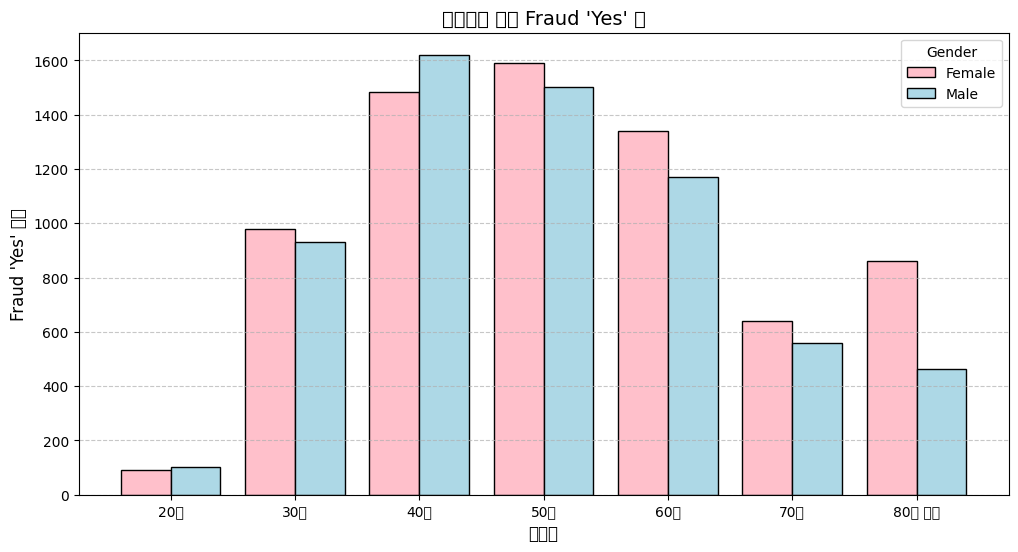

In [18]:
merge["fraud"] = merge["fraud"].astype(str)
merge["current_age"] = merge["current_age"].astype(int)
merge["gender"] = merge["gender"].astype(str)

# 나이대를 정의
def age_group(age):
    if age < 30:
        return "20대"
    elif age < 40:
        return "30대"
    elif age < 50:
        return "40대"
    elif age < 60:
        return "50대"
    elif age < 70:
        return "60대"
    elif age < 80:
        return "70대"
    else:
        return "80대 이상"

# 나이대 컬럼 추가
merge["age_group"] = merge["current_age"].apply(age_group)

# fraud가 'Yes'인 경우만 필터링
fraud_yes = merge[merge["fraud"] == "Yes"]

# 나이대와 성별별로 그룹화하여 횟수 집계
age_gender_counts = fraud_yes.groupby(["age_group", "gender"]).size().unstack(fill_value=0)

# 모든 나이대를 포함하도록 재정렬 (누락된 나이대 처리)
all_age_groups = ["20대", "30대", "40대", "50대", "60대", "70대", "80대 이상"]
age_gender_counts = age_gender_counts.reindex(all_age_groups, fill_value=0)

# 막대그래프 시각화
x = np.arange(len(all_age_groups))  # 각 나이대의 x축 위치
width = 0.4  # 막대 너비

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, age_gender_counts["Female"], width, label="Female", color="pink", edgecolor="black")
plt.bar(x + width/2, age_gender_counts["Male"], width, label="Male", color="lightblue", edgecolor="black")

# 그래프 설정
plt.title("나이대별 성별 Fraud 'Yes' 수", fontsize=14)
plt.xlabel("나이대", fontsize=12)
plt.ylabel("Fraud 'Yes' 횟수", fontsize=12)
plt.xticks(x, all_age_groups, fontsize=10)  # x축 눈금에 나이대 추가
plt.legend(title="Gender", fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

뭐가 문제인지 모르겠지만 한글은 여전히 깨진다